# Unknown Phase Problem

In the following, I am trying to give an intuitive explanation of what we call the Unknown Phase Problem. This problem only affects the Koopman algorithm and directly stems from using a non-linear link between oscillator and data and coordinate descent. In a sense, it's the price you pay for non-linearity.

## Recap

The Koopman- and Fourier-algorithms make the following assumptions of the data $x_t$, respectively:

$$
x_t = A\Omega(\vec{\omega}t) \\
x_t = f_\Theta(\Omega(\vec{\omega}t))
$$

The training process minimizes some loss w.r.t. ($A$ or $\Theta$) and $\vec{\omega}$. This is achieved by performing coordinate descent. Coordinate descent optimizes a (set of) parameters whilst keeping the remaining parameters fixed.

The problem that arises for the Koopman algorithm when optimizing $\omega_i$ is that "bad guesses" of $\Theta$ obstruct the view on $\omega_i$. However, the same is not true for the Fourier-algorithm.
The reason why this problem does not affect the Fourier algorithm is the following: When deriving the analytical expression for the error surface, because of the linearity of $A$, we can derive an expression for $\frac{\partial E}{\partial A} = 0$ which in turn allows us to eliminate $A$ from the expression of the error function $E$. In other words, $A$ does not obstruct the view on $E$.

However, because the Koopman algorithm is non-linear, the same strategy does not work. Eliminating $\Theta$ from the equation would require training a Neural Network to convergence for every possible value $\omega_i$ can take.

## Illustration

In the following, the intuition presented above is explained by some easy coding examples.

Text(0, 0.5, 'Error')

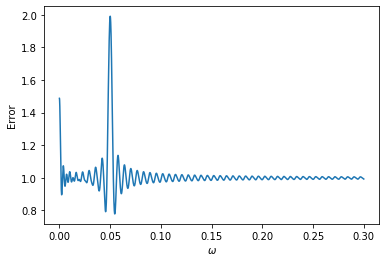

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

a_guess = 1 #current guess of optimal a
a_true = -1 #true value of a
w_true = 0.05 #true frequency
T = 1000 #number of data points
data_true = a_true * np.cos(np.arange(T)*w_true)

#Brute force computation of the error surface
E = [] #errors for specific w_guess
for w_guess in np.linspace(0,0.3,10001):
    
    data_guess = a_guess * np.cos(np.arange(T)*w_guess)
    e = np.mean((data_guess - data_true)**2)
    E.append(e)
    
plt.plot(np.linspace(0,0.3,10001), E)
plt.xlabel('$\omega$')
plt.ylabel('Error')


Even though $\omega = 0.05$ is the correct guess, $E$ indicates that $\omega = 0.05$ is the worst $\omega$ to choose. This is caused by the fact that the guess of $a$ was incorrect.

We can remedy the problem by computing the optimal $a$ for every guess of $\omega$.

Text(0, 0.5, 'Error')

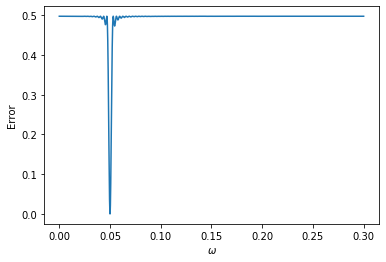

In [23]:
# a_guess is not required anymore
a_true = -1 #true value of a
w_true = 0.05 #true frequency
T = 1000 #number of data points
data_true = a_true * np.cos(np.arange(T)*w_true)

#Brute force computation of the error surface
E = [] #errors for specific w_guess
for w_guess in np.linspace(0,0.3,10001):
    
    data_guess = np.cos(np.arange(T)*w_guess)
    optimal_a_for_w_guess = 2*np.mean(data_guess*data_true)
    
    e = np.mean((optimal_a_for_w_guess*data_guess - data_true)**2)
    E.append(e)
    
plt.plot(np.linspace(0,0.3,10001), E)
plt.xlabel('$\omega$')
plt.ylabel('Error')

By computing the optimal $a$ for every guess of the frequency $\omega$, we can correctly identify the correct guess of the frequency. Note that the code above is horribly inefficient because we can exploit analytic knowledge of optimal $A$, as being done by the Fourier algorithm.

However, this strategy breaks down for the Koopman algorithm because computing the optimal $\Theta$ for every guess of the frequency is computationally too expensive to carry out even for modest model sizes.

## Potential remedies
For the Koopman algorithm, the inability to have an unobstructed view on the frequencies results in instabilities, i.e. the frequencies never converge and as a result $\Theta$ does not converge. This makes using the Koopman algorithm difficult to use in practice as it requires multiple runs from different initial conditions and "hoping for convergence".

Note that the symptoms of the Unknown Phase Problem appear to be very similar for the linear (Fourier) and non-linear (Koopman) case, namely that correct frequencies can cause a up-spike in the error surface.

The question is whether or not we can mitigate this problem. In the following some ideas/strategies are collected:

*  <b> Median subtraction: </b> The error surface seems to always exhibit some plateau and an up- or down-spike can indicate a "good frequency". The idea of median subtraction is simple: Extract the value of the plateau (median of $E$ works well), subtract the median and take the absolute value of $E$ and then choose the frequency that maximizes $E$, because all spikes are flipped to the upward direction. Even though we did not mention this strategy in the paper, it was used to obtain the power systems results presented in the paper.

However, it is easy to create scenarios where the median subtraction strategy fails:

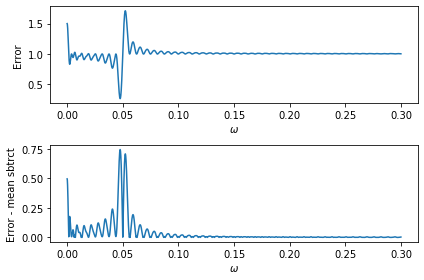

In [24]:
a_guess = 1 #current guess of optimal a
a_true = 1 #this is in reality an imaginary number because the true data is generated by a sin
w_true = 0.05 #true frequency
T = 1000 #number of data points
data_true = a_true * np.sin(np.arange(T)*w_true) #sin!

#Brute force computation of the error surface
E = [] #errors for specific w_guess
for w_guess in np.linspace(0,0.3,10001):
    
    data_guess = a_guess * np.cos(np.arange(T)*w_guess)
    e = np.mean((data_guess - data_true)**2)
    E.append(e)
    
E_ms = np.array(E)
E_ms = np.abs(E-np.median(E))
    
plt.subplot(2,1,1)
plt.plot(np.linspace(0,0.3,10001), E)
plt.xlabel('$\omega$')
plt.ylabel('Error')

plt.subplot(2,1,2)
plt.xlabel('$\omega$')
plt.ylabel('Error - mean sbtrct')
plt.plot(np.linspace(0,0.3,10001), E_ms)
plt.tight_layout()

Note that ideally the mean subtraction strategy would cause a spike at $0.05$. However, instead it created a double peak around $0.05$. Also, the peak has lost some "energy", i.e. it is not as high as it should be (it should go all the way up to 1).

*  <b> Error warping: </b> The (untested) idea of error warping is the following: For small and linear problems, we can artificially induce the pathologies of median subtraction. Can we find some function $f$ such that $E_{true} = f(E_{median subtract})$? Once such a function is estimated, we could check how well it works on actual non-linear problems.